# MAST Table Access Protocol PanSTARRS 1 DR2 Demo

<br> This tutorial demonstrates how to use astroquery to access PanSTARRS 1 Data Release 2 via a Virtual Observatory standard Table Access Protocol (TAP) service at MAST, and work with the resultant data. It relies on Python 3 and astroquery, as well as some other common scientific packages.

***
### Table of Contents

1. [TAP Service Introduction](#TAP-Service-Introduction)
2. [Imports](#Imports)
3. [Connecting to a TAP Service](#Connecting-to-a-TAP-Service)
4. [Use Cases](#Use-Cases)
5. [Additional Resources](#Additional-Resources)
6. [About This Notebook](#About-this-Notebook)
***

## TAP Service Introduction

Table Access Protocol (TAP) services allow more direct and flexible access to astronomical data than the simpler types of IVOA standard data services. Queries are built with the SQL-like Astronomical Data Query Language (ADQL), and can include geographic / spatial queries as well as filtering on other characteristics of the data. This also allows the user fine-grained control over the returned columns, unlike the fixed set of coumns returned from cone, image, and spectral services.

For this example, we'll be using the astroquery TAP/TAP+ client, which was developed by the ESAC Space Data Centre for working with the GAIA catalog, but is interoperable with other valid TAP services, including those at MAST. As an astroquery project, TAP+ documentation is available at ReadTheDocs: http://astroquery.readthedocs.io/en/latest/utils/tap.html

We'll be using TAP+ to call the TAP service at MAST serving PanSTARRS 1 Data Release 2, now with individual detection information. The schema is described within the service, and we'll show how to inspect it. The schema is also the same as the one available via the CasJobs interface, with an additional view added for the most common positional queries. CasJobs has its own copy of the schema documentation, which can be accessed through its own site: http://mastweb.stsci.edu/ps1casjobs/



***
## Imports

In [1]:
# Use the astroquery TapPlus library as our client to the data service.
from astroquery.utils.tap.core import TapPlus

# For resolving objects with tools from MAST
from astroquery.mast import Mast

# For handling ordinary astropy Tables in responses
from astropy.table import Table

# For displaying and manipulating some types of results
%matplotlib inline
import requests
import astropy
import numpy as np
import pylab
import time
import json
from matplotlib import pyplot as plt

# For calling the object name resolver. Note these are Python 3 dependencies
#import sys
#import http.client as httplib 
#from urllib.parse import quote as urlencode
#from urllib.request import urlretrieve

# To allow display tweaks for wider response tables
from IPython.core.display import display
from IPython.core.display import HTML

***
## Connecting to a TAP Service

The TapPlus library is able to connect to any TAP service, given the "base" URL as noted in metadata registry resources describing the service. This is the URL for the PanSTARRS 1 DR2 TAP service.

In [2]:
TAP_service = TapPlus(url="http://vao.stsci.edu/PS1DR2/tapservice.aspx")

Created TAP+ (v1.0.1) - Connection:
	Host: vao.stsci.edu
	Use HTTPS: False
	Port: 80
	SSL Port: 443


### List available tables

In [3]:
tables = TAP_service.load_tables(only_names=True)
for table in tables:
    print(table.name)

Retrieving tables...


Parsing tables...
Done.
dbo.ForcedMeanLensing
dbo.ForcedMeanObject
dbo.ForcedMeanObjectView
dbo.Detection
dbo.DetectionFlags
dbo.DetectionFlags2
dbo.DetectionFlags3
dbo.DetectionObjectView
dbo.DiffDetection
dbo.DiffDetEffMeta
dbo.DiffDetObject
dbo.DiffDetObjectView
dbo.DiffMeta
dbo.DiffToImage
dbo.DiffType
dbo.Filter
dbo.FitModel
dbo.ForcedGalaxyModelView
dbo.ForcedGalaxyShape
dbo.ForcedGalaxyShapeFlags
dbo.FrameMeta
dbo.ImageDetEffMeta
dbo.ImageFlags
dbo.ImageMeta
dbo.MeanObject
dbo.MeanObjectView
dbo.ObjectFilterFlags
dbo.ObjectInfoFlags
dbo.ObjectQualityFlags
dbo.ObjectThin
dbo.PhotoCal
dbo.StackApFlx
dbo.StackApFlxExGalCon6
dbo.StackApFlxExGalCon6ObjectView
dbo.StackApFlxExGalCon8
dbo.StackApFlxExGalCon8ObjectView
dbo.StackApFlxExGalUnc
dbo.StackApFlxExGalUncObjectView
dbo.StackApFlxObjectView
dbo.StackDetEffMeta
dbo.StackMeta
dbo.StackModelFitDeV
dbo.StackModelFitDeVObjectView
dbo.StackModelFitExp
dbo.StackModelFitExpObjectView
dbo.StackModelFitExtra
dbo.StackModelFitPetObjectView

# Use Cases

## Simple Positional Query

This searches the mean object catalog for objects within .2 degrees of M87 (RA=187.706, Dec=12.391 in degrees). The view used contains information from the [ObjectThin](https://outerspace.stsci.edu/x/W4Oc) table (which has information on object positions and the number of available measurements) and the [MeanObject](https://outerspace.stsci.edu/x/WYOc) table (which has information on photometry averaged over the multiple epochs of observation).

Note that the results are restricted to objects with `nDetections>1`, where `nDetections` is the total number of times the object was detected on the single-epoch images in any filter at any time.  Objects with `nDetections=1` tend to be  artifacts, so this is a quick way to eliminate most spurious objects from the catalog.

This query runs in TAP's asynchronous mode, which is a queued batch mode with some overhead and longer timeouts, useful for big catalogs like PanSTARRS. It may not be necessary for all queries to PS1 DR2, but the TAP+ client can automatically handle the additional processing required over synchronous mode.

In [4]:
job = TAP_service.launch_job_async("""
SELECT objID, RAMean, DecMean, nDetections, ng, nr, ni, nz, ny, gMeanPSFMag, rMeanPSFMag, iMeanPSFMag, zMeanPSFMag, yMeanPSFMag
FROM dbo.MeanObjectView
WHERE
CONTAINS(POINT('ICRS', RAMean, DecMean),CIRCLE('ICRS',187.706,12.391,.2))=1
AND nDetections > 1
  """)
TAP_results = job.get_results()
TAP_results

Query finished.


objID,RAMean,DecMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
,deg,deg,,,,,,,mag,mag,mag,mag,mag
int64,float64,float64,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32
122651877046324801,187.70467078,12.21190893,2,0,1,0,0,1,-999.0,21.9684,-999.0,-999.0,20.2631
122651877046975413,187.70459815,12.21241363,2,1,0,1,0,0,22.052,-999.0,21.9873,-999.0,-999.0
122651877053267117,187.70522081,12.21386907,2,1,0,1,0,0,21.5524,-999.0,21.9783,-999.0,-999.0
122651877064756563,187.70636965,12.21349016,51,0,12,14,11,14,-999.0,21.1322,20.2316,20.001,19.6865
122651877092070446,187.70917592,12.2083584,41,0,8,16,12,5,-999.0,21.5268,20.9639,20.591,20.0405
122651877096732213,187.70962312,12.20977059,71,15,16,16,13,11,21.1283,20.5565,20.363,20.2741,19.9642
122651877126896562,187.71270121,12.21329618,3,0,2,0,1,0,-999.0,21.6698,-999.0,20.8441,-999.0
122651877127435758,187.71278373,12.21270177,23,0,4,12,7,0,-999.0,21.4659,21.2041,20.8953,-999.0


## Get DR2 light curve for RR Lyrae star KQ UMa

This time we start with the object name, use the MAST name resolver (which relies on Simbad and NED) to convert the name to RA and Dec, and then query the PS1 DR2 mean object catalog at that position.  Then we run a spatial query to TAP using those coordinates.

In [5]:
objname = 'KQ UMa'
coords = Mast._resolve_object(objname)
ra,dec = coords.ra.value,coords.dec.value
radius = 1.0/3600.0 # radius = 1 arcsec

query = """
SELECT objID, RAMean, DecMean, nDetections, ng, nr, ni, nz, ny, gMeanPSFMag, 
    rMeanPSFMag, iMeanPSFMag, zMeanPSFMag, yMeanPSFMag
FROM dbo.MeanObjectView
WHERE
CONTAINS(POINT('ICRS', RAMean, DecMean),CIRCLE('ICRS',{},{},{}))=1
AND nDetections > 1
""".format(ra,dec,radius)
print(query)

job = TAP_service.launch_job_async(query)
TAP_results = job.get_results()
TAP_results


SELECT objID, RAMean, DecMean, nDetections, ng, nr, ni, nz, ny, gMeanPSFMag, 
    rMeanPSFMag, iMeanPSFMag, zMeanPSFMag, yMeanPSFMag
FROM dbo.MeanObjectView
WHERE
CONTAINS(POINT('ICRS', RAMean, DecMean),CIRCLE('ICRS',139.3344625554179,68.6350884268329,0.0002777777777777778))=1
AND nDetections > 1



Query finished.


objID,RAMean,DecMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
,deg,deg,,,,,,,mag,mag,mag,mag,mag
int64,float64,float64,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32
190361393344112894,139.33444972,68.6350604,66,8,10,21,13,14,15.0402,14.553,14.2109,14.2814,14.3041


### Get Repeated Detection Information

Extract all the objects with the same object ID from the [Detection](https://outerspace.stsci.edu/x/b4Oc) table, which contains all the individual measurements for this source. The results are joined to the [Filter](https://outerspace.stsci.edu/x/nIOc) table to convert the filter numbers to names.

In [6]:
objid = TAP_results['objID'][0]
query = """
SELECT
    objID, detectID, Detection.filterID as filterID, Filter.filterType, obsTime, ra, dec,
    psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
    apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
FROM Detection
NATURAL JOIN Filter
WHERE objID={}
ORDER BY filterID, obsTime
""".format(objid)
print(query)

job = TAP_service.launch_job_async(query)
detection_TAP_results = job.get_results()
detection_TAP_results


SELECT
    objID, detectID, Detection.filterID as filterID, Filter.filterType, obsTime, ra, dec,
    psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
    apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
FROM Detection
NATURAL JOIN Filter
WHERE objID=190361393344112894
ORDER BY filterID, obsTime



Query finished.


objID,detectID,filterid,filterType,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3
,,,,,deg,deg,,,,,,,,,,
int64,int64,uint8,bytes100,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,int64,int32,int32
190361393344112894,153347716310000010,1,g,55634.477414,139.3345207,68.63503577,0.00826192,1.14074e-05,1.88185,1.76734,0.992916,0.00861705,1.14233e-05,102760517,128,124782656
190361393344112894,153348968310000008,1,g,55634.4899457,139.33448821,68.63506146,0.0077373,1.10268e-05,1.81031,1.60518,0.998461,0.00792172,1.09406e-05,102760517,128,124782656
190361393344112894,232228791560000017,1,g,56423.2881719,139.33449441,68.63503952,0.00335198,7.26745e-06,1.60204,1.45048,0.998589,0.00338658,7.2363e-06,102760517,128,108038208
190361393344112894,255559866370000015,1,g,56656.5989211,139.33444592,68.63504589,0.00372909,7.37688e-06,1.82831,1.68692,0.999191,0.00372163,7.52088e-06,102760517,128,124815424
190361393344112894,262040070370000016,1,g,56721.4009635,139.33445148,68.63504807,0.003576,7.22894e-06,1.60585,1.50396,0.998605,0.00359603,7.43463e-06,102760517,128,7374912
190361393344112894,262040708370000014,1,g,56721.4073411,139.33445304,68.63504406,0.00350554,7.14809e-06,1.62415,1.48827,0.999487,0.00359624,7.43434e-06,102760517,128,7374912
190361393344112894,264231864260000022,1,g,56743.3189045,139.3344431,68.63504497,0.00343867,7.81574e-06,1.53957,1.4761,0.999049,0.00361239,7.85237e-06,102760517,128,7374912
190361393344112894,264232516260000024,1,g,56743.3254198,139.33444512,68.63505285,0.00347403,7.87789e-06,1.52751,1.43325,0.999367,0.00360349,7.8686e-06,102760517,128,7374912


### Plot the light curves

The `psfFlux` values from the Detection table are converted from Janskys to AB magnitudes.  Measurements in the 5 different filters are plotted separately.

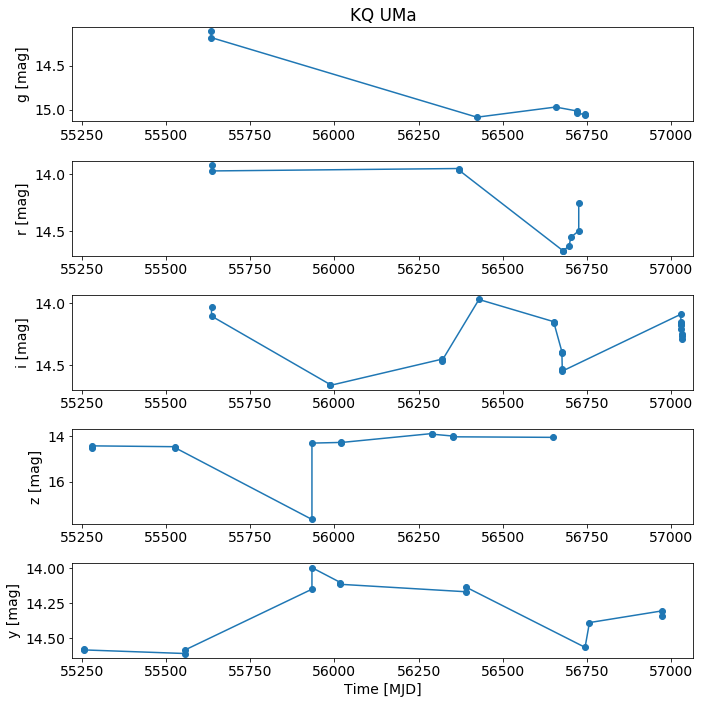

In [7]:
# convert flux in Jy to magnitudes
t = detection_TAP_results['obsTime']
mag = -2.5*np.log10(detection_TAP_results['psfFlux']) + 8.90
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))

#detection_TAP_results['filterType'] is a byte string, compare accordingly:
for i, filter in enumerate([b'g',b'r',b'i',b'z',b'y']):
    pylab.subplot(511+i)
    w = np.where(detection_TAP_results['filterType']==filter)    
    pylab.plot(t[w],mag[w],'-o')
    pylab.ylabel(filter.decode('ascii')+' [mag]')
    pylab.xlim(xlim)
    pylab.gca().invert_yaxis()
    if i==0:
        pylab.title(objname)
        
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

Plot differences from the mean magnitudes in the initial search.

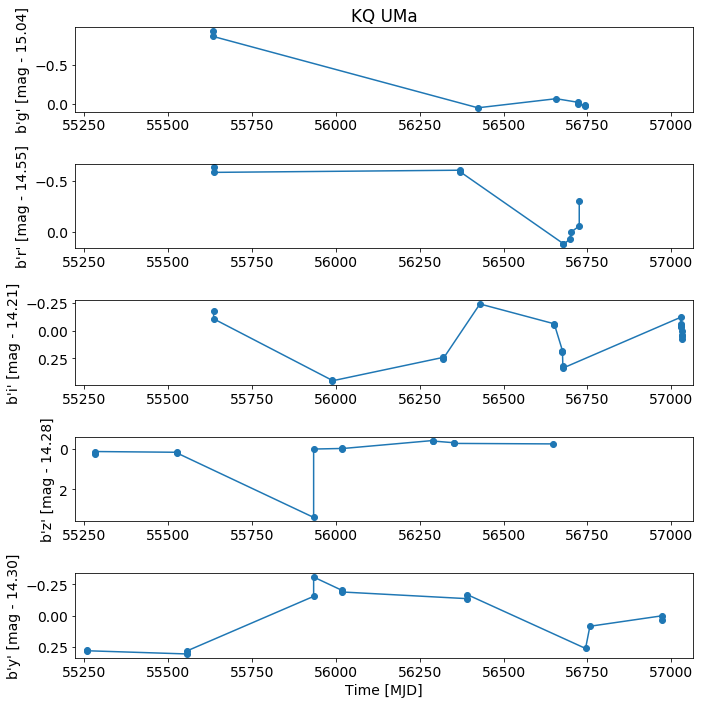

In [8]:
# convert flux in Jy to magnitudes
t = detection_TAP_results['obsTime']
mag = -2.5*np.log10(detection_TAP_results['psfFlux']) + 8.90
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))

#detection_TAP_results['filterType'] is a byte string, compare accordingly:
for i, filter in enumerate([b'g',b'r',b'i',b'z',b'y']):
    pylab.subplot(511+i)
    w = np.where(detection_TAP_results['filterType']==filter)
    magmean = TAP_results[filter.decode('ascii')+'MeanPSFMag'][0]
    pylab.plot(t[w],mag[w] - magmean,'-o')
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean))
    pylab.xlim(xlim)
    pylab.gca().invert_yaxis()
    if i==0:
        pylab.title(objname)
        
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

### Identify bad data

There is one clearly bad $z$ magnitude with a very large difference.  Select the bad point and look at it in more detail.

Note that indexing a table (or numpy array) with a logical expression selects just the rows where that expression is true.

In [9]:
detection_TAP_results[ (detection_TAP_results['filterType']=='z') & (np.abs(mag-TAP_results['zMeanPSFMag'][0]) > 2) ]

objID,detectID,filterid,filterType,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3
,,,,,deg,deg,,,,,,,,,,
int64,int64,uint8,bytes100,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,int64,int32,int32
190361393344112894,183252627520000234,4,z,55933.5264577,139.33488168,68.63532273,0.000317945,6.73008e-06,1.07537,1.0153,0.322986,0.000213217,2.36939e-06,102760453,128,32768


From examining this table, it looks like `psfQfPerfect` is bad.  This flag is the PSF-weighted fraction of unmasked pixels in the image (see the [documentation](https://outerspace.stsci.edu/x/IoOc) for more details). Values near unity indicate good data that is not significantly affected by bad pixels.

Check all the `psfQfPerfect` values for the $z$ filter to see if this value really is unusual.  The list of values below are sorted by magnitude.  The bad point is the only value with `psfQfPerfect` < 0.95.

In [10]:
w = np.where(detection_TAP_results['filterType']=='z')
zdtab = detection_TAP_results[w]
zdtab['mag'] = mag[w]
zdtab['dmag'] = zdtab['mag'] - TAP_results['zMeanPSFMag'][0]
ii = np.argsort(-np.abs(zdtab['dmag']))
zdtab = zdtab[ii]
zdtab['objID','obsTime','mag','dmag','psfQfPerfect']

objID,obsTime,mag,dmag,psfQfPerfect
int64,float64,float32,float32,float32
190361393344112894,55933.5264577,17.64412,3.3627195,0.322986
190361393344112894,56289.6159346,13.890659,-0.3907404,0.997811
190361393344112894,56289.6241112,13.916805,-0.36459446,0.988369
190361393344112894,56351.4168483,13.998972,-0.2824278,0.999257
190361393344112894,55281.2528285,14.537914,0.25651455,0.99754
190361393344112894,56351.424076,14.032501,-0.2488985,0.999187
190361393344112894,55527.6508919,14.512117,0.23071766,0.997265
190361393344112894,56648.5676019,14.05643,-0.22496986,0.997982
190361393344112894,55527.6381469,14.46514,0.18374062,0.99738


### Repeat the plot with bad psfQfPerfect values excluded

Do the plot again but exclude low psfQfPerfect values.

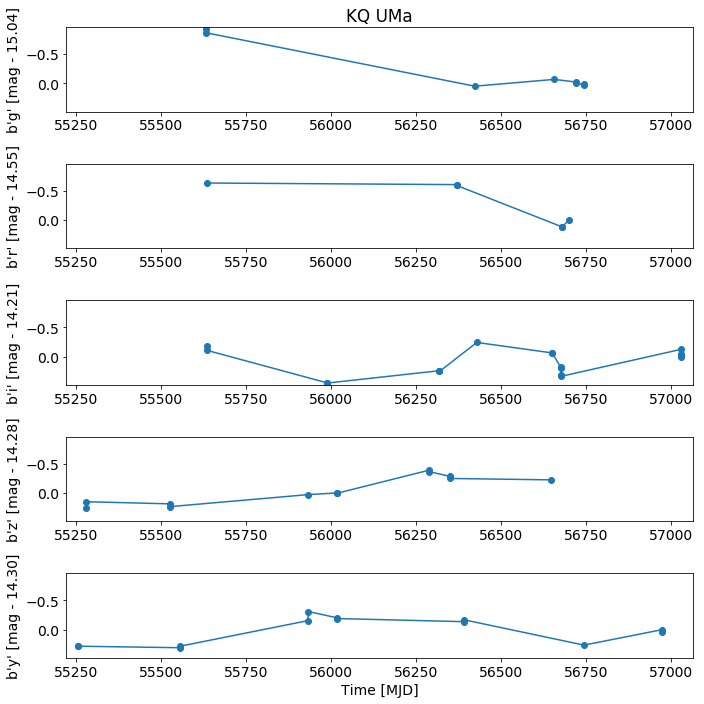

In [11]:
# convert flux in Jy to magnitudes
t = detection_TAP_results['obsTime']
mag = -2.5*np.log10(detection_TAP_results['psfFlux']) + 8.90
magmean = 0.0*mag
for i, filter in enumerate([b'g',b'r',b'i',b'z',b'y']):
    magmean[detection_TAP_results['filterType']==filter] = TAP_results[filter.decode('ascii')+'MeanPSFMag'][0]

dmag = mag - magmean
dmag1 = dmag[detection_TAP_results['psfQfPerfect']>0.9]
# fix the x and y axis ranges
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
# flip axis direction for magnitude
ylim = np.array([dmag1.max(),dmag1.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))

for i, filter in enumerate([b'g',b'r',b'i',b'z',b'y']):
    pylab.subplot(511+i)
    w = np.where((detection_TAP_results['filterType']==filter) & (detection_TAP_results['psfQfPerfect']>0.9))[0]
    pylab.plot(t[w],dmag[w],'-o')
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean[w[0]]))
    pylab.xlim(xlim)
    pylab.ylim(ylim)
    if i==0:
        pylab.title(objname)
        
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

### Plot versus the periodic phase instead of epoch

Plot versus phase using known RR Lyr period from Simbad (table [J/AJ/132/1202/table4](http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/AJ/132/1202/table4&-c=KQ%20UMa&-c.u=arcmin&-c.r=2&-c.eq=J2000&-c.geom=r&-out.max=50&-out.form=HTML%20Table&-oc.form=sexa)).

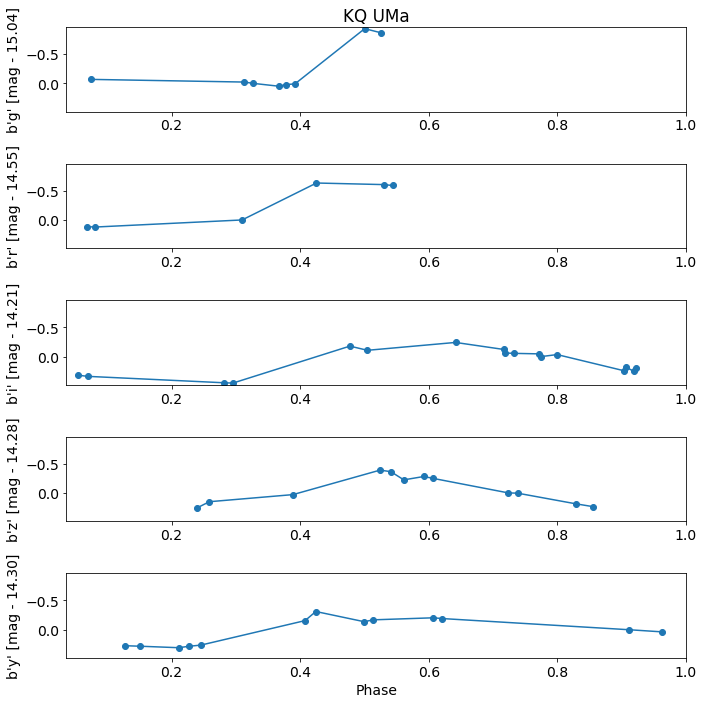

In [12]:
period = 0.48636 #days, from Simbad
# convert flux in Jy to magnitudes
t = (detection_TAP_results['obsTime'] % period) / period
mag = -2.5*np.log10(detection_TAP_results['psfFlux']) + 8.90
magmean = 0.0*mag
for i, filter in enumerate([b'g',b'r',b'i',b'z',b'y']):
    magmean[detection_TAP_results['filterType']==filter] = TAP_results[filter.decode('ascii')+'MeanPSFMag'][0]
    
dmag = mag - magmean
dmag1 = dmag[detection_TAP_results['psfQfPerfect']>0.9]
# fix the x and y axis ranges
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
# flip axis direction for magnitude
ylim = np.array([dmag1.max(),dmag1.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))

for i, filter in enumerate([b'g',b'r',b'i',b'z',b'y']):
    pylab.subplot(511+i)
    w = np.where((detection_TAP_results['filterType']==filter) & (detection_TAP_results['psfQfPerfect']>0.9))[0]
    w = w[np.argsort(t[w])]
    pylab.plot(t[w],dmag[w],'-o')
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean[w[0]]))
    pylab.xlim(xlim)
    pylab.ylim(ylim)
    if i==0:
        pylab.title(objname)
        
pylab.xlabel('Phase')
pylab.tight_layout()

## Repeat search using eclipsing binary KIC 2161623

From [Villanova Kepler Eclipsing Binaries](http://keplerebs.villanova.edu)

In [13]:
objname = 'KIC 2161623'
coords = Mast._resolve_object(objname)
ra,dec = coords.ra.value,coords.dec.value
radius = 1.0/3600.0 # radius = 1 arcsec

query = """
SELECT objID, RAMean, DecMean, nDetections, ng, nr, ni, nz, ny, gMeanPSFMag, rMeanPSFMag, iMeanPSFMag, zMeanPSFMag, yMeanPSFMag
FROM dbo.MeanObjectView
WHERE
CONTAINS(POINT('ICRS', RAMean, DecMean),CIRCLE('ICRS',{},{},{}))=1
AND nDetections > 1
""".format(ra,dec,radius)
print(query)

job = TAP_service.launch_job_async(query)
TAP_results = job.get_results()
TAP_results


SELECT objID, RAMean, DecMean, nDetections, ng, nr, ni, nz, ny, gMeanPSFMag, rMeanPSFMag, iMeanPSFMag, zMeanPSFMag, yMeanPSFMag
FROM dbo.MeanObjectView
WHERE
CONTAINS(POINT('ICRS', RAMean, DecMean),CIRCLE('ICRS',291.7444617740266,37.5910012223162,0.0002777777777777778))=1
AND nDetections > 1



Query finished.


objID,RAMean,DecMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
,deg,deg,,,,,,,mag,mag,mag,mag,mag
int64,float64,float64,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32
153102917444859851,291.74446451,37.5910001,67,10,16,12,15,14,14.5998,14.2821,14.1587,14.2004,14.0672


### Get Repeated Detection Information

This time include the `psfQfPerfect` limit directly in the database query.

In [14]:
objid = TAP_results['objID'][0]

query = """
SELECT
    objID, detectID, Detection.filterID as filterID, Filter.filterType, obsTime, ra, dec,
    psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
    apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
FROM Detection
NATURAL JOIN Filter
WHERE objID={}
AND psfQfPerfect >= 0.9
ORDER BY filterID, obsTime
""".format(objid)
print(query)

job = TAP_service.launch_job_async(query)
detection_TAP_results = job.get_results()

# add magnitude and difference from mean
detection_TAP_results['magmean'] = 0.0
for i, filter in enumerate([b'g',b'r',b'i',b'z',b'y']):
    detection_TAP_results['magmean'][detection_TAP_results['filterType']==filter] = TAP_results[filter.decode('ascii')+'MeanPSFMag'][0]
detection_TAP_results['mag'] = -2.5*np.log10(detection_TAP_results['psfFlux']) + 8.90
detection_TAP_results['dmag'] = detection_TAP_results['mag']-detection_TAP_results['magmean']

detection_TAP_results


SELECT
    objID, detectID, Detection.filterID as filterID, Filter.filterType, obsTime, ra, dec,
    psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
    apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
FROM Detection
NATURAL JOIN Filter
WHERE objID=153102917444859851
AND psfQfPerfect >= 0.9
ORDER BY filterID, obsTime



Query finished.


objID,detectID,filterid,filterType,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3,magmean,mag,dmag
,,,,,deg,deg,,,,,,,,,,,,,
int64,int64,uint8,bytes100,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,int64,int32,int32,float64,float32,float64
153102917444859851,90150443710000088,1,g,55002.5047803,291.74446391,37.5910006,0.00501008,6.65687e-06,1.98744,1.81211,0.999421,0.00517413,7.31225e-06,102760517,128,124815424,14.599800109863281,14.650389,0.05058860778808594
153102917444859851,90151959710000087,1,g,55002.5199475,291.74446611,37.59100156,0.00487334,6.48844e-06,1.98487,1.70793,0.999234,0.00511542,7.27714e-06,102760517,128,124815424,14.599800109863281,14.680433,0.08063316345214844
153102917444859851,131534996560000129,1,g,55416.3502179,291.74446082,37.59099692,0.00525622,8.41646e-06,1.62403,1.57893,0.998566,0.0052992,8.62578e-06,102760517,128,7374912,14.599800109863281,14.598316,-0.001483917236328125
153102917444859851,131536180650000138,1,g,55416.362065,291.74445937,37.59099733,0.00533028,8.62169e-06,1.32081,1.27186,0.998757,0.00540082,8.91577e-06,102760517,128,124815424,14.599800109863281,14.583125,-0.01667499542236328
153102917444859851,204528930560000076,1,g,56146.2895546,291.74445914,37.59098073,0.00522399,8.43794e-06,1.33369,1.29211,0.999758,0.00532506,8.88465e-06,102760517,128,7374912,14.599800109863281,14.604994,0.0051937103271484375
153102917444859851,204530041560000085,1,g,56146.3006673,291.74446486,37.59097649,0.00523539,8.44281e-06,1.42883,1.22683,0.964646,0.00532419,8.85594e-06,102760517,128,7374912,14.599800109863281,14.602627,0.002826690673828125
153102917444859851,241032265120000094,1,g,56511.322909,291.74445657,37.59099752,0.00528641,8.3427e-06,1.15123,1.10789,0.998722,0.00537484,8.8135e-06,102760517,128,7374912,14.599800109863281,14.592098,-0.007701873779296875
153102917444859851,241033321120000081,1,g,56511.3334693,291.74445945,37.59099643,0.00527889,8.31263e-06,1.07898,0.987323,0.995279,0.0053346,8.77771e-06,102760517,128,7374912,14.599800109863281,14.593643,-0.00615692138671875


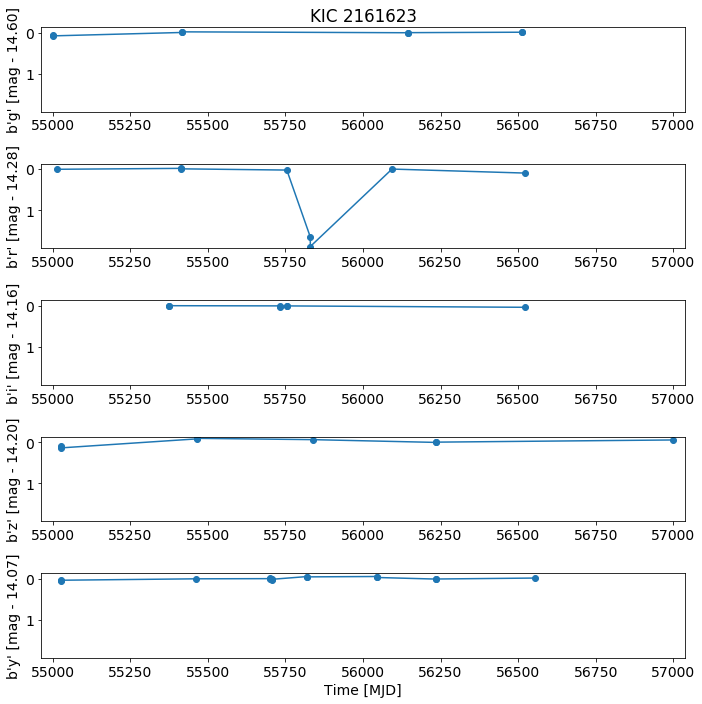

In [15]:
t = detection_TAP_results['obsTime']
dmag = detection_TAP_results['dmag']
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
ylim = np.array([dmag.max(),dmag.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))

for i, filter in enumerate([b'g',b'r',b'i',b'z',b'y']):
    pylab.subplot(511+i)
    w = np.where(detection_TAP_results['filterType']==filter)[0]
    pylab.plot(t[w],dmag[w],'-o')
    magmean = detection_TAP_results['magmean'][w[0]]
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean))
    pylab.xlim(xlim)
    pylab.ylim(ylim)
    if i==0:
        pylab.title(objname)
        
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

### Plot versus phase using known period

Eclipsing binaries basically vary by same amount in all filters since it is a geometrical effect, so combine the data into a single light curve.  Wrap using known period and plot versus phase.

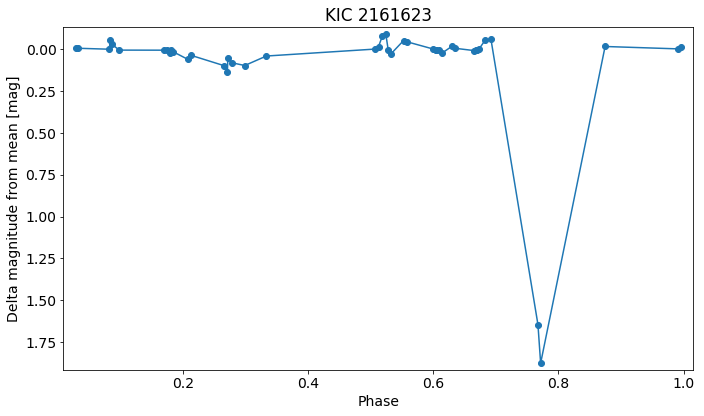

In [16]:
period = 2.2834698
bjd0 = 54999.599837
t = ((detection_TAP_results['obsTime']-bjd0) % period) / period
dmag = detection_TAP_results['dmag']
w = np.argsort(t)
t = t[w]
dmag = dmag[w]
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
ylim = np.array([dmag.max(),dmag.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,6))
pylab.plot(t,dmag,'-o')
pylab.xlim(xlim)
pylab.ylim(ylim)
pylab.xlabel('Phase')
pylab.ylabel('Delta magnitude from mean [mag]')
pylab.title(objname)
pylab.tight_layout()

## Repeat search for another eclipsing binary KIC 8153568

In [17]:
objname = 'KIC 8153568'
coords = Mast._resolve_object(objname)
ra,dec = coords.ra.value,coords.dec.value
radius = 1.0/3600.0 # radius = 1 arcsec

query = """
SELECT objID, RAMean, DecMean, nDetections, ng, nr, ni, nz, ny, gMeanPSFMag, rMeanPSFMag, iMeanPSFMag, zMeanPSFMag, yMeanPSFMag
FROM dbo.MeanObjectView
WHERE
CONTAINS(POINT('ICRS', RAMean, DecMean),CIRCLE('ICRS',{},{},{}))=1
AND nDetections > 1
""".format(ra,dec,radius)
print(query)

job = TAP_service.launch_job_async(query)
TAP_results = job.get_results()
TAP_results


SELECT objID, RAMean, DecMean, nDetections, ng, nr, ni, nz, ny, gMeanPSFMag, rMeanPSFMag, iMeanPSFMag, zMeanPSFMag, yMeanPSFMag
FROM dbo.MeanObjectView
WHERE
CONTAINS(POINT('ICRS', RAMean, DecMean),CIRCLE('ICRS',286.9044623840081,44.0054993799163,0.0002777777777777778))=1
AND nDetections > 1



Query finished.


objID,RAMean,DecMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
,deg,deg,,,,,,,mag,mag,mag,mag,mag
int64,float64,float64,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32
160802869044447231,286.90444402,44.00547369,88,16,15,31,10,16,15.1825,14.9899,14.8907,15.1999,14.8484


In [18]:
objid = TAP_results['objID'][0]
query = """
SELECT
    objID, detectID, Detection.filterID as filterID, Filter.filterType, obsTime, ra, dec,
    psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
    apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
FROM Detection
NATURAL JOIN Filter
WHERE objID={}
AND psfQfPerfect >= 0.9
ORDER BY filterID, obsTime
""".format(objid)
print(query)

job = TAP_service.launch_job_async(query)
detection_TAP_results = job.get_results()

# add magnitude and difference from mean
detection_TAP_results['magmean'] = 0.0
for i, filter in enumerate([b'g',b'r',b'i',b'z',b'y']):
    detection_TAP_results['magmean'][detection_TAP_results['filterType']==filter] = TAP_results[filter.decode('ascii')+'MeanPSFMag'][0]
detection_TAP_results['mag'] = -2.5*np.log10(detection_TAP_results['psfFlux']) + 8.90
detection_TAP_results['dmag'] = detection_TAP_results['mag']-detection_TAP_results['magmean']

detection_TAP_results


SELECT
    objID, detectID, Detection.filterID as filterID, Filter.filterType, obsTime, ra, dec,
    psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
    apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
FROM Detection
NATURAL JOIN Filter
WHERE objID=160802869044447231
AND psfQfPerfect >= 0.9
ORDER BY filterID, obsTime



Query finished.


objID,detectID,filterid,filterType,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3,magmean,mag,dmag
,,,,,deg,deg,,,,,,,,,,,,,
int64,int64,uint8,bytes100,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,int64,int32,int32,float64,float32,float64
160802869044447231,91336429430000113,1,g,55014.3646518,286.90443374,44.00547575,0.003109,5.98065e-06,1.78,1.23811,0.998335,0.00312447,5.69291e-06,102760517,128,7374912,15.182499885559082,15.1684475,-0.014052391052246094
160802869044447231,91337480430000116,1,g,55014.3751566,286.90443894,44.00547502,0.00313056,6.00144e-06,1.66939,1.32773,0.998197,0.00315613,5.71358e-06,102760517,128,124815424,15.182499885559082,15.160945,-0.021554946899414062
160802869044447231,126057565120000092,1,g,55361.57592,286.90445317,44.00547451,0.00309573,6.72312e-06,1.7498,1.62422,0.998826,0.00310045,6.69387e-06,102760517,128,7374912,15.182499885559082,15.173092,-0.009407997131347656
160802869044447231,126058741130000111,1,g,55361.587678,286.90445157,44.00548065,0.00302815,6.57752e-06,1.62839,1.52579,0.998387,0.0031062,6.76425e-06,102760517,128,7374912,15.182499885559082,15.197056,0.014555931091308594
160802869044447231,128744126310000284,1,g,55388.4415151,286.9044502,44.00547891,0.000806462,3.51444e-06,1.10132,0.992501,0.997631,0.000810416,3.45294e-06,102760517,128,124815424,15.182499885559082,16.63354,1.4510393142700195
160802869044447231,128745341310000249,1,g,55388.4536712,286.90445043,44.00547936,0.000981762,3.82737e-06,1.1085,1.07441,0.997491,0.000985584,3.78859e-06,102760517,128,124815424,15.182499885559082,16.419983,1.237483024597168
160802869044447231,164544841720000097,1,g,55746.4486739,286.90445315,44.00547646,0.00306655,6.32653e-06,1.32851,1.16693,0.99831,0.00304733,6.63894e-06,102760517,128,40929344,15.182499885559082,15.183374,0.0008745193481445312
160802869044447231,164744408530000111,1,g,55748.4443394,286.90445207,44.00547835,0.00304057,6.5461e-06,1.37153,1.23193,0.998544,0.00307828,6.69725e-06,102760517,128,7374912,15.182499885559082,15.192612,0.010111808776855469


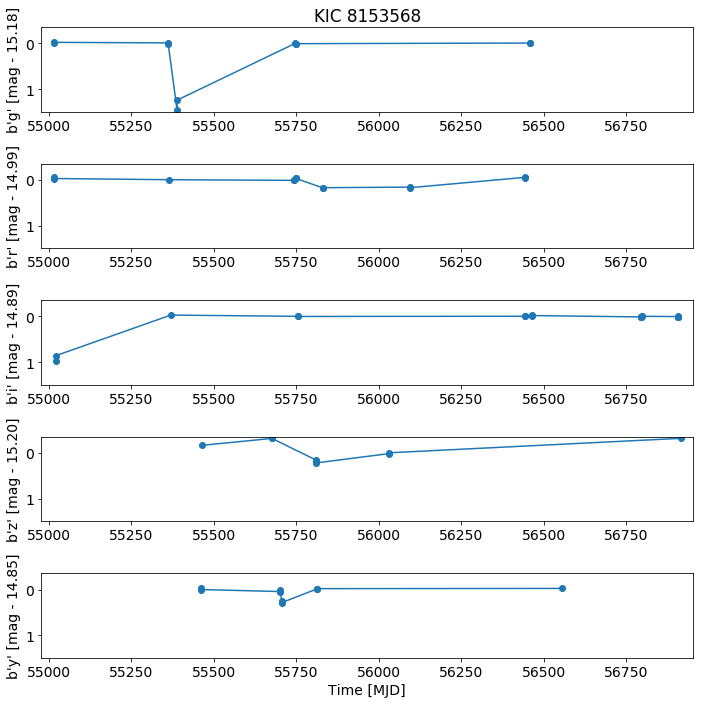

In [19]:
t = detection_TAP_results['obsTime']
dmag = detection_TAP_results['dmag']
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
ylim = np.array([dmag.max(),dmag.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))

for i, filter in enumerate([b'g',b'r',b'i',b'z',b'y']):
    pylab.subplot(511+i)
    w = np.where(detection_TAP_results['filterType']==filter)[0]
    pylab.plot(t[w],dmag[w],'-o')
    magmean = detection_TAP_results['magmean'][w[0]]
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean))
    pylab.xlim(xlim)
    pylab.ylim(ylim)
    if i==0:
        pylab.title(objname)
        
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

Eclipsing binaries basically vary by same amount in all filters since it is a geometrical effect, so combine the data into a single light curve.

Wrap using known period and plot versus phase.  Plot two periods of the light curve this time.

This nice light curve appears to show a secondary eclipse.

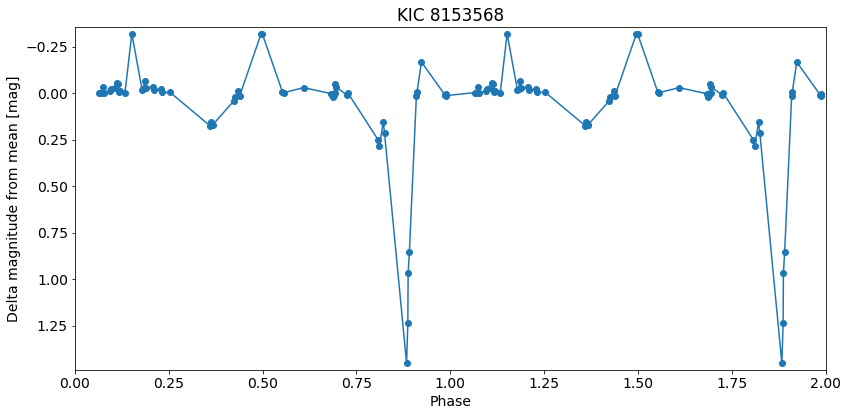

In [20]:
period = 3.6071431
bjd0 = 54999.289794
t = ((detection_TAP_results['obsTime']-bjd0) % period) / period
dmag = detection_TAP_results['dmag']
w = np.argsort(t)
# extend to two periods
nw = len(w)
w = np.append(w,w)
t = t[w]
# add one to second period
t[-nw:] += 1
dmag = dmag[w]
xlim = [0,2.0]
ylim = np.array([dmag.max(),dmag.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(12,6))
pylab.plot(t,dmag,'-o')
pylab.xlim(xlim)
pylab.ylim(ylim)
pylab.xlabel('Phase')
pylab.ylabel('Delta magnitude from mean [mag]')
pylab.title(objname)
pylab.tight_layout()

***
# Additional Resources


## Table Access Protocol 
* IVOA standard for RESTful web service access to tabular data
* http://www.ivoa.net/documents/TAP/

## PanSTARRS 1 DR 2
* Catalog for PanSTARRS with additional Detection information
* https://outerspace.stsci.edu/display/PANSTARRS/

## Astronomical Query Data Language (2.0)
* IVOA standard for querying astronomical data in tabular format, with geometric search support
* http://www.ivoa.net/documents/latest/ADQL.html

## TapPlus 
* Module created by ESAC Space Data Centre
* http://astroquery.readthedocs.io/en/latest/utils/tap.html

***

## About this Notebook
**Authors:** Rick White & Theresa Dower, STScI Archive Scientist & Software Engineer
**Updated On:** 02/27/2019

***

<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 